## Sampling exploration

__Starting with Evan's CSE HW code. It is probably better as a class, but for the sake of consistency with my other components, I am going to recast as a function.__

This code is for the Frank Wolfe algorithm which should allow us to D-optimally sample our dataset. This is going to be somewhat computationally expensive, but we should be able to get a sufficient training set out of it. The class returns lamb, a probability distribution, and D_lamb which I believe to be a sort of error that can be used for convergence testing. I am going to work under this assumption for now. The final lamb distribution can be applied to the original dataset using the 'p' parameter in numpy.random.choice().

This notebook will contain initial exploration of Evan's code, checking against real ValidProt data (small), and recasting as function process. The finished code will be moved to c2.

In [82]:
import time

In [85]:
# Evan's code
import scipy.stats
from typing import List
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_style('whitegrid')
sns.set_context('talk')

def sample_X(d: int, a: float, n: int):
    def sample_xi(d: int, a: float):
        sigma2s = [j**(-a) for j in range(1,d+1)]
        return np.array(np.random.normal(0, np.sqrt(sigma2s))).reshape(1,-1)
    return np.concatenate([sample_xi(d, a) for i in range(n)])

class FrankWolfe:
    """
    Attributes
    ----------
    X : (n, d) matrix of arms
    XXT : (n, d, d) matrix of self interaction
    lamb : (n,1) vector of arm distribution
    A : (d, d) matrix of weighted self interactions
    """
    def __init__(self, X: np.ndarray, N: int):
        d = X.shape[1]
        n = X.shape[0]
        
        self.d = d

        self.n = n
        self.N = N
        self.X = X
        self.startup()
        return
    
    def startup(self):
        # pull first 2d arms and set lambda
        pulls = np.random.choice(list(range(self.n)), size=(2*self.d))
        values, counts_ = np.unique(pulls, return_counts=True)
        counts = []
        for i in range(self.n):
            if i in values:
                counts.append(counts_[np.argwhere(values==i)][0][0])
            else:
                counts.append(0)
        self.lamb = (np.array(counts)/(2*self.d)).reshape(-1,1)
        # start time after startup
        self.t = 2*self.d
        # the raw XXT matrix
        xs = []
        for x in self.X:
            xs.append(np.matmul(x.reshape(-1,1), x.reshape(1,-1)))
        self.XXT = np.array(xs)
        return
    
    @property
    def A(self):
        """Function of current lambda"""
        return np.sum(self.lamb.reshape(-1,1,1)*self.XXT, axis=0)
    
    @property
    def D_lamb(self):
        return -np.log(np.linalg.det(self.A))
        
    def update_for_next(self, arm_index):
        """Update lambda and time at the end of the iteration."""
        #print('updating')
        indicator = np.zeros((self.n,1))
        indicator[arm_index] = 1
        # at this lambda and t are both at their end of previous iteration state, eg t has not been updated
        self.lamb = (self.lamb*self.t + indicator)/(self.t+1)
        self.t += 1
        #print(f'updated to {self.t}')
        return
    
    def g_prime_i(self, i):
        """Compute gradient of design equation for one example's lambda"""
        return -np.matmul(np.matmul(self.X[i].reshape(1,-1), np.linalg.inv(self.A)),  self.X[i].reshape(-1,1))
    
    def take_step(self):
        # get the gradient vector
        #print('starting take_step')
        self.g_prime = np.concatenate([self.g_prime_i(i) for i in range(self.n)])
        It = np.argmin(self.g_prime)
        self.update_for_next(It)
        # print(f'Time {self.t}, pull {It}, D = {self.D_lamb}')
        return 
    
    def run(self):
        while self.t < self.N:
            self.take_step()
        return self.lamb, self.D_lamb

In [18]:
# Features identified for model by Logan. We can exclude any that do not have significant tails to save comp time.
features = ['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 
            'scaled_local_symmetric_percent_id', 'query_align_len', 'query_align_cov',
            'subject_align_len', 'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len']

In [10]:
df = pd.read_csv('/mnt/c/Users/ryanf/Desktop/learn2therm_sample_50k.csv').sample(100)

In [19]:
arr = df[features].to_numpy()

In [20]:
# Run first test with 10 x n iterations
samp = FrankWolfe(arr, 1000)

samp.startup()

lamb, D_lamb = samp.run()

(array([85.,  2.,  1.,  0.,  0.,  1.,  4.,  2.,  2.,  3.]),
 array([0.    , 0.0097, 0.0194, 0.0291, 0.0388, 0.0485, 0.0582, 0.0679,
        0.0776, 0.0873, 0.097 ]),
 <BarContainer object of 10 artists>)

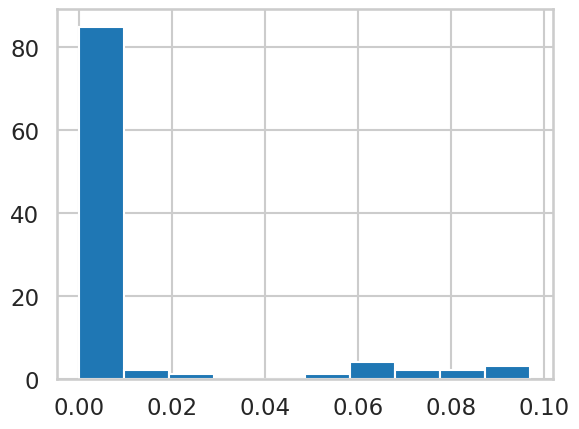

In [23]:
plt.hist(lamb)

__Ok. This looks like it runs and returns a few samples with relatively high probability.__

In [25]:
D = []
for i in range(10):
    samp = FrankWolfe(df_3, i*100)
    samp.startup()
    _ , D_lamb = samp.run()
    D.append(D_lamb)

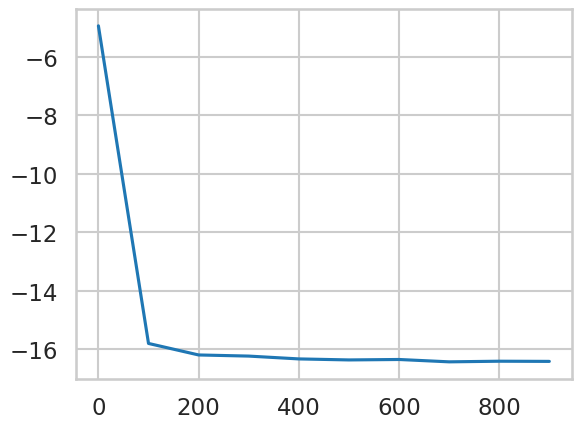

In [28]:
# Plotting D_lamb as a function of # of iterations
plt.plot([i*100 for i in range(10)], D)

Looks like it converges after ~400 iterations. For the sake of testing, I will use this number.

In [51]:
def fw_temp(df = df_3, it = 400):
    samp = FrankWolfe(df, it)
    samp.startup()
    lamb, D_lamb = samp.run()
    return lamb, D_lamb

In [30]:
# Get lamb
lamb, _ = fw_temp()

In [41]:
sample = np.random.choice(range(df_3.shape[0]), 25, p = lamb.flatten())

In [42]:
# These are the chosen indices
sample

array([63, 36, 92, 70, 36,  0, 88, 72, 53, 70, 92, 92, 72, 54, 50, 42, 88,
       36, 36, 44, 72, 44, 70, 72, 31])

In [43]:
sample_df = df.iloc[sample]

In [44]:
sample_df.head()

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len
49225,49225,0.608247,0.578431,0.566400,289,0.944444,294,0.921630,880,7134,...,1180.0,28.0,52.5,24.5,MGLRRIAGNTLKATAAVGAVGAACVAYAALVEVRWFTLRKVTVPVL...,MWQPVTVHPLLKVTATALAGTAVAGAACLAYAAGYEVRAYRLRRFD...,metallophosphoesterase,metallophosphoesterase,319,306
1772,1772,0.461538,0.382979,0.112853,38,0.808511,41,0.150735,68,7760,...,1015.0,25.0,50.0,25.0,MQEPLLTKPPKGEVAAEPKDGGNMVDAQHLVKTFGKLEVVKDLSFT...,MSKHKQPALRRADHILVLKAGQIEAEGTLEELLTQSSEMQRLWFETD,ATP-binding cassette domain-containing protein,ABC transporter ATP-binding protein/permease,272,47
43830,43830,0.278481,0.137072,0.140800,175,0.545171,156,0.513158,89,7134,...,1024.0,28.0,52.5,24.5,MTTTEPVRTAAAVGGAAPAKPRPPLAARIAARAGGGVMRVVLVLVA...,MTATEAPGRRRAGGVVTDAPPRVDTAPAVSRRRRALRPYLLAVPAV...,carbohydrate ABC transporter permease,sugar ABC transporter permease,304,321
39928,39928,0.868132,0.840426,0.831579,91,0.968085,91,0.947917,406,3226,...,956.0,30.0,59.0,29.0,MLRLDLQFFASKKGVGSTKNGRDSIAKRLGAKRADGQFVTGGSILY...,MLKMNLQFFAQKKGVGSTKNGRDSIAKRLGVKRGDGQFVTAGSILV...,50S ribosomal protein L27,50S ribosomal protein L27,96,94
1772,1772,0.461538,0.382979,0.112853,38,0.808511,41,0.150735,68,7760,...,1015.0,25.0,50.0,25.0,MQEPLLTKPPKGEVAAEPKDGGNMVDAQHLVKTFGKLEVVKDLSFT...,MSKHKQPALRRADHILVLKAGQIEAEGTLEELLTQSSEMQRLWFETD,ATP-binding cassette domain-containing protein,ABC transporter ATP-binding protein/permease,272,47


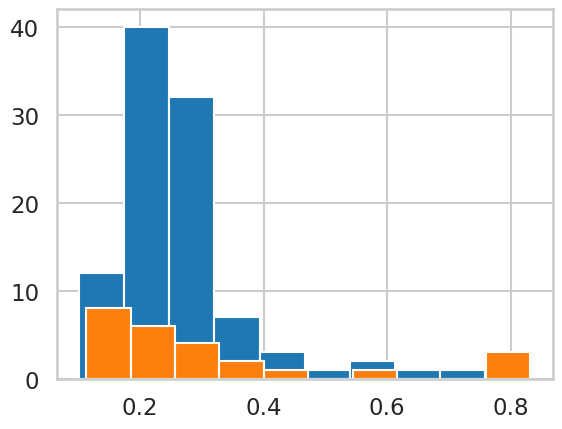

In [53]:
# Overlay histograms to see how distribution changes
f = features[2]
plt.hist(df[f]);
plt.hist(sample_df[f]);

Algorithm clearly favors extreme values. This is good! I think at least for the sake of CHEME 545/546 this will be sufficient.

__Next let's identify which features we can drop at this step.__

In [54]:
len(features)

10

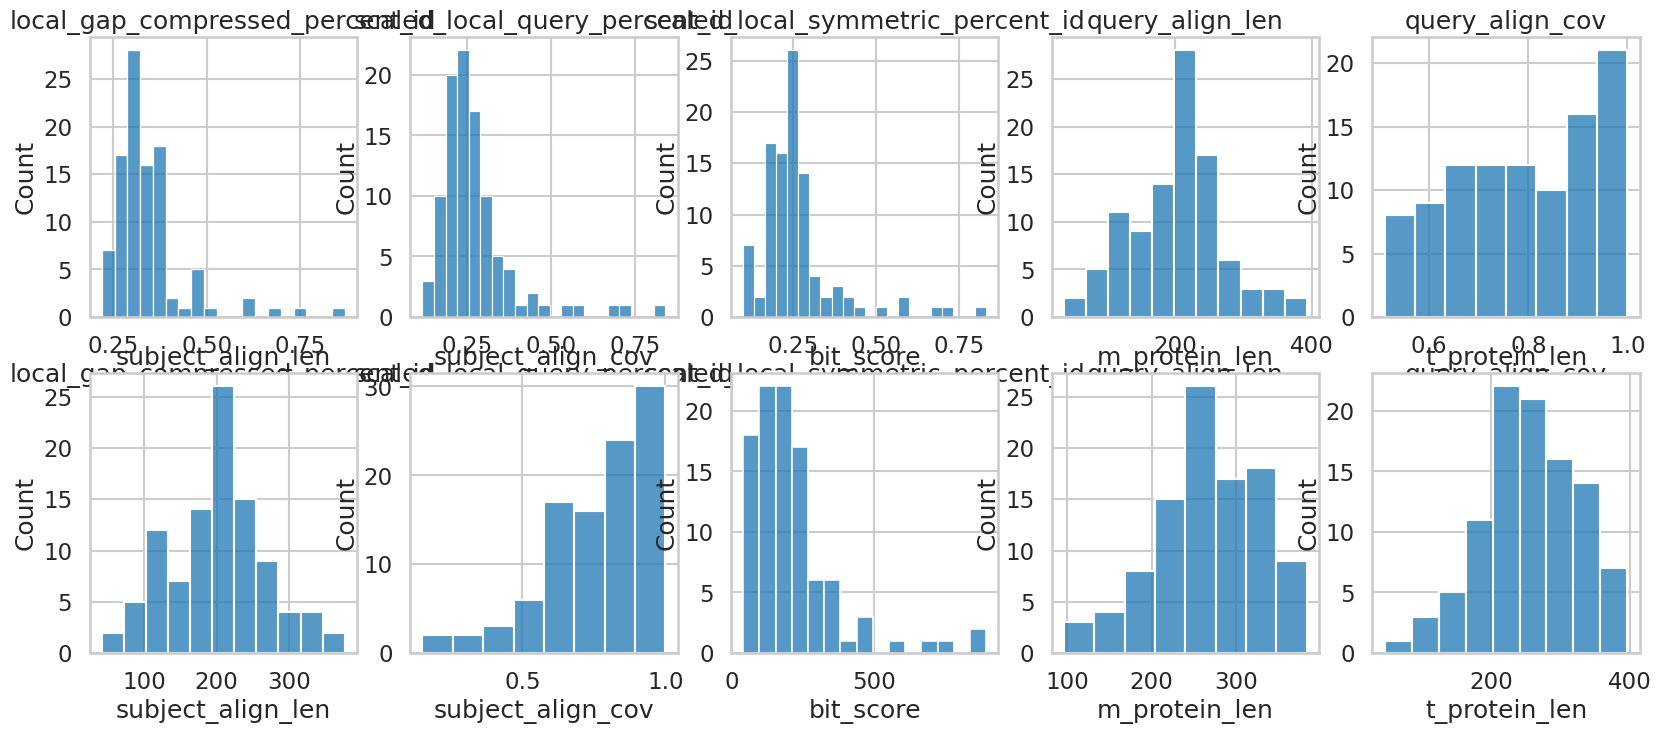

In [64]:
fig, ax = plt.subplots(2,5, figsize = (20, 8))

for i,f in enumerate(features):
    w = i%5
    h = int(i/5)
    sns.histplot(data = df, x = f, ax = ax[h,w])
    ax[h,w].set_title(f)

We can probably drop query_align_cov since it does not have significant tails. There should be some input in c2 that will automatically go through each feature and decide whether to keep for Frank Wolfe.

In [65]:
new_features = ['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 
            'scaled_local_symmetric_percent_id', 'query_align_len', 'subject_align_len', 
                'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len']

In [80]:
# Trying with a bigger sample size: 10000 choose 100
df = pd.read_csv('/mnt/c/Users/ryanf/Desktop/learn2therm_sample_50k.csv').sample(10000)
arr = df[new_features].sample(1000).to_numpy()

In [81]:
lamb, D = fw_temp(arr, it = 100)

starting take_step
updating
updated to 19
starting take_step
updating
updated to 20
starting take_step
updating
updated to 21
starting take_step
updating
updated to 22
starting take_step
updating
updated to 23
starting take_step
updating
updated to 24
starting take_step
updating
updated to 25
starting take_step
updating
updated to 26
starting take_step
updating
updated to 27
starting take_step
updating
updated to 28
starting take_step
updating
updated to 29
starting take_step
updating
updated to 30
starting take_step
updating
updated to 31
starting take_step
updating
updated to 32
starting take_step
updating
updated to 33
starting take_step
updating
updated to 34
starting take_step
updating
updated to 35
starting take_step
updating
updated to 36
starting take_step
updating
updated to 37
starting take_step
updating
updated to 38
starting take_step
updating
updated to 39
starting take_step
updating
updated to 40
starting take_step
updating
updated to 41
starting take_step
updating
update

KeyboardInterrupt: 

In [ ]:
sample = np.random.choice(range(df.shape[0]), 100, p = lamb.flatten())

In [ ]:
sample_df = df.iloc[sample]

In [ ]:
fig, ax = plt.subplots(2,5, figsize = (20, 8))

for i,f in enumerate(new_features):
    w = i%5
    h = int(i/5)
    sns.histplot(data = df, x = f, ax = ax[h,w])
    sns.histplot(data = sample_df, x = f, ax = ax[h,w])
    ax[h,w].set_title(f)

In [83]:
df = pd.read_csv('/mnt/c/Users/ryanf/Desktop/learn2therm_sample_50k.csv')


In [84]:


st = time.time()

arr = df[new_features].sample(1000).to_numpy()
lamb, D = fw_temp(arr, it = 500)

et = time.time()
print(f'Elapsed: {et-st}')

starting take_step
updating
updated to 19
starting take_step
updating
updated to 20
starting take_step
updating
updated to 21
starting take_step
updating
updated to 22
starting take_step
updating
updated to 23
starting take_step
updating
updated to 24
starting take_step
updating
updated to 25
starting take_step
updating
updated to 26
starting take_step
updating
updated to 27
starting take_step
updating
updated to 28
starting take_step
updating
updated to 29
starting take_step
updating
updated to 30
starting take_step
updating
updated to 31
starting take_step
updating
updated to 32
starting take_step
updating
updated to 33
starting take_step
updating
updated to 34
starting take_step
updating
updated to 35
starting take_step
updating
updated to 36
starting take_step
updating
updated to 37
starting take_step
updating
updated to 38
starting take_step
updating
updated to 39
starting take_step
updating
updated to 40
starting take_step
updating
updated to 41
starting take_step
updating
update

updating
updated to 211
starting take_step
updating
updated to 212
starting take_step
updating
updated to 213
starting take_step
updating
updated to 214
starting take_step
updating
updated to 215
starting take_step
updating
updated to 216
starting take_step
updating
updated to 217
starting take_step
updating
updated to 218
starting take_step
updating
updated to 219
starting take_step
updating
updated to 220
starting take_step
updating
updated to 221
starting take_step
updating
updated to 222
starting take_step
updating
updated to 223
starting take_step
updating
updated to 224
starting take_step
updating
updated to 225
starting take_step
updating
updated to 226
starting take_step
updating
updated to 227
starting take_step
updating
updated to 228
starting take_step
updating
updated to 229
starting take_step
updating
updated to 230
starting take_step
updating
updated to 231
starting take_step
updating
updated to 232
starting take_step
updating
updated to 233
starting take_step
updating
up

updating
updated to 402
starting take_step
updating
updated to 403
starting take_step
updating
updated to 404
starting take_step
updating
updated to 405
starting take_step
updating
updated to 406
starting take_step
updating
updated to 407
starting take_step
updating
updated to 408
starting take_step
updating
updated to 409
starting take_step
updating
updated to 410
starting take_step
updating
updated to 411
starting take_step
updating
updated to 412
starting take_step
updating
updated to 413
starting take_step
updating
updated to 414
starting take_step
updating
updated to 415
starting take_step
updating
updated to 416
starting take_step
updating
updated to 417
starting take_step
updating
updated to 418
starting take_step
updating
updated to 419
starting take_step
updating
updated to 420
starting take_step
updating
updated to 421
starting take_step
updating
updated to 422
starting take_step
updating
updated to 423
starting take_step
updating
updated to 424
starting take_step
updating
up